In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nutritional-values-for-common-foods-and-products/nutrition.csv


**Импортируем дополнительные библиотеки**

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

**Загружаем dataset и проверям загрузку**

In [25]:
df = pd.read_csv('/kaggle/input/nutritional-values-for-common-foods-and-products/nutrition.csv')

Данные были успешно загружены. Мы имеем 77 колонок для дальнейшей работы.

**Делаем первычный осмотр данных первых 5 строк**

In [26]:
display(df.head())

,Unnamed: 0,name,serving_size,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,...,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water
0,0,Cornstarch,100 g,381,0.1g,NaN,0,9.00 mg,0.4 mg,0.00 mcg,...,0.05 g,0.009 g,0.016 g,0.025 g,0.00 mg,0.0 g,0.09 g,0.00 mg,0.00 mg,8.32 g
1,1,"Nuts, pecans",100 g,691,72g,6.2g,0,0.00 mg,40.5 mg,22.00 mcg,...,71.97 g,6.180 g,40.801 g,21.614 g,0.00 mg,0.0 g,1.49 g,0.00 mg,0.00 mg,3.52 g
2,2,"Eggplant, raw",100 g,25,0.2g,NaN,0,2.00 mg,6.9 mg,22.00 mcg,...,0.18 g,0.034 g,0.016 g,0.076 g,0.00 mg,0.0 g,0.66 g,0.00 mg,0.00 mg,92.30 g
3,3,"Teff, uncooked",100 g,367,2.4g,0.4g,0,12.00 mg,13.1 mg,0,...,2.38 g,0.449 g,0.589 g,1.071 g,0,0,2.37 g,0,0,8.82 g
4,4,"Sherbet, orange",100 g,144,2g,1.2g,1mg,46.00 mg,7.7 mg,4.00 mcg,...,2.00 g,1.160 g,0.530 g,0.080 g,1.00 mg,0.0 g,0.40 g,0.00 mg,0.00 mg,66.10 g


Dataset содержит информацию о питательной ценности различных продуктов. Каждая строка представляет отдельный продукт. 
1. Идентификаторы:
    1.1. Unnamed- Идентификатор строки
    1.2. Name- Название продукта
    1.3. Serving_size- Размер порции
2. Основные нутриенты: 
    2.1 Calories- Калорийность на 100 грамм продукта
    2.2 Protein- Белки
    2.3 Fat- Жиры
    2.4 Total_fat- Общее количество жиров
    2.5 Carbohydrate- Углеводы
    2.6 Fiber- Клетчатка
    2.7 Sugars- Сахара
3. Витамины:
    3.1 Витамины А, В(В1-12), C, D, E, K
    3.2 Каротиноиды
4. Минералы:
    4.1 Calcium- Кальций
    4.2 Irom- Железо(в базе имеется ошибка, iron)
    4.3 Magnesium- Магний
    4.4 Zinc- Цинк(в базе имеется ошибка zink)
    4.5 Selenium- Селен
    4.6 Potassium- Калий
    4.7 Sodium- Натрий
5. Амиокислоты(20+ колонок):
    5.1 Alanine, arginine, aspartic_acid и т.д.
6. Углеводные компоненты:
    6.1 Fructose, glucose, lactose, maltose, sucrose
7. Прочие компоненты:
    7.1 Alcohol, caffeine, theobromine, water, ash

**Проверка типов данных и пропусков**

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8789 entries, 0 to 8788
Data columns (total 77 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Unnamed: 0                   8789 non-null   int64 
 1   name                         8789 non-null   object
 2   serving_size                 8789 non-null   object
 3   calories                     8789 non-null   int64 
 4   total_fat                    8789 non-null   object
 5   saturated_fat                7199 non-null   object
 6   cholesterol                  8789 non-null   object
 7   sodium                       8789 non-null   object
 8   choline                      8789 non-null   object
 9   folate                       8789 non-null   object
 10  folic_acid                   8789 non-null   object
 11  niacin                       8789 non-null   object
 12  pantothenic_acid             8789 non-null   object
 13  riboflavin                   8789

Информация о данных: dataset имеет 8789 строк и 77 колон. В таблице имеется 3 числовых столбца и 74 категориальных. Для дальнейшей работы с данными нам необходимо будет доработать нанные и перевести их в числовые значения. 
Также в колонке saturated_fat имеется 7199 значений вместо 8789, пропуски необходимо будет устранить.

**Делаем проверку пропущенных значений и выводим даннные на тепловой карте**

Распределение пропущенных значений в датасете.
Просмотри на теловой карте пропущенные значения и имеющиеся данные.

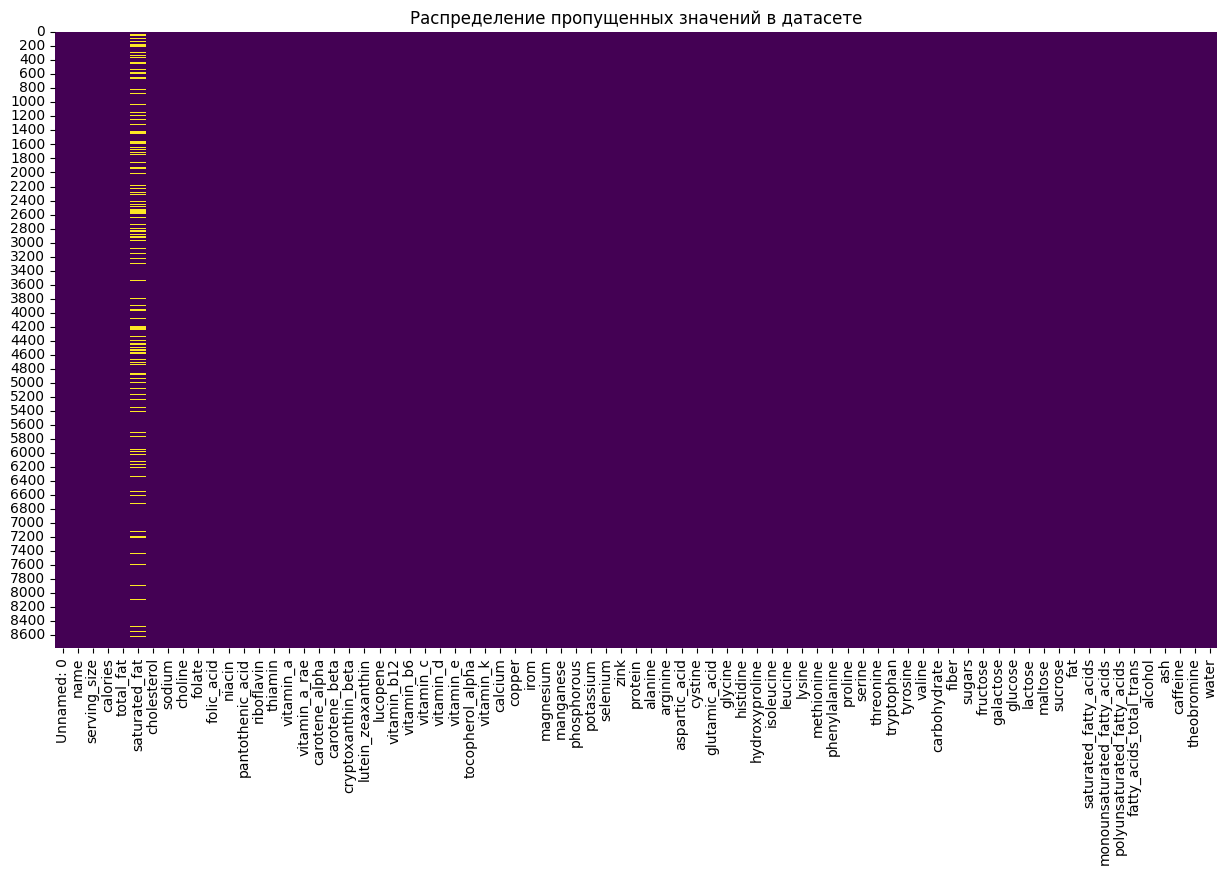

In [28]:
plt.figure(figsize=(15, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Распределение пропущенных значений в датасете')
plt.show()

На тепловой карте видно, что колонка saturated_fat содержат много пропущенных значений. Для анализа, который буду делать я, необходимы колонки с питательными веществами, которые имеют меньше пропусков.

**Очистка числовых значений от единиц измерения**

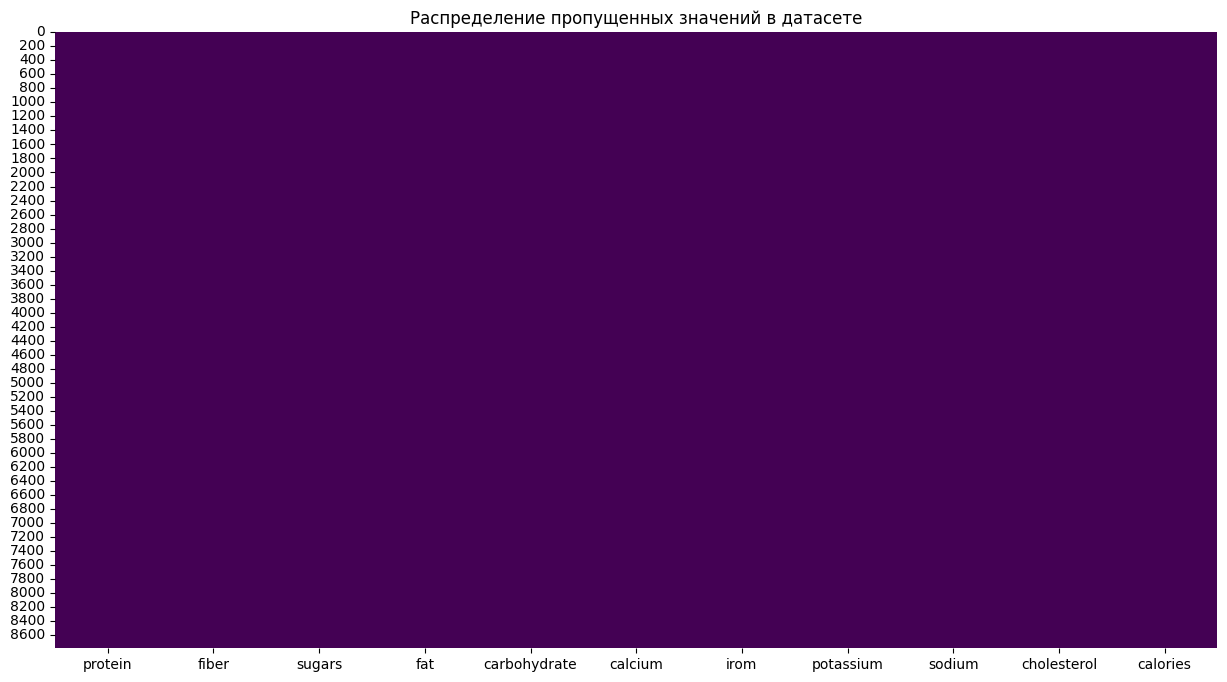

In [29]:
def clean_numeric(value):
    if isinstance(value, str):
        cleaned = ''.join(c for c in value if c.isdigit() or c in {'.', '-'})
        return float(cleaned) if cleaned else np.nan
    return value

nutrients = ['protein', 'fiber', 'sugars', 'fat', 'carbohydrate', 
             'calcium', 'irom', 'potassium', 'sodium', 'cholesterol', 'calories']

df_clean = df.copy()
for col in nutrients:
    df_clean[col] = df_clean[col].apply(clean_numeric)

plt.figure(figsize=(15, 8))
sns.heatmap(df_clean[nutrients].isnull(), cbar=False, cmap='viridis')
plt.title('Распределение пропущенных значений в датасете')
plt.show()

df_clean = df_clean.dropna(subset=['calories'] + nutrients[:-1])

Создана функция для очистки числовых значений от единиw измерения, в ней мы удаляем все нечисловые значения кроме точки и минуса. Очищаем все столбцы которые нам понадобятся для вычисления корреляции. Далее делаем анализ пропущенных значений и делаем удаление строк с пропусками в целевой переменной и основных нутриентах.

**Обоснование выбора нутриентов**

1. Базовые макронутриенты:
    1.1 Белки- структурные компоненты организма
    1.2 Жиры- энергетический резерв
    1.3 Углеводы- основной источник энергии
2. Критические микроэлементы:
    2.1 Кальций- ключевой элемент костной ткани
    2.2 Железо- транспорт кислорода(гемоглобин)
    2.3 Калий- нейромышечная регуляция
3. Метаболические маркеры:
    3.1 Пищевые волокна- индикатор "цельности" продукта
    3.2 Сахара- дифференциация на внутренние и добавленные
    3.3 Холестерин- липидный профиль крови
4. Электролитный баланс:
    4.4 Натрий
    4.5 Калий
5. Энергетическая ценность:
    5.1 Калории

Text(0, 0.5, 'Содержание')

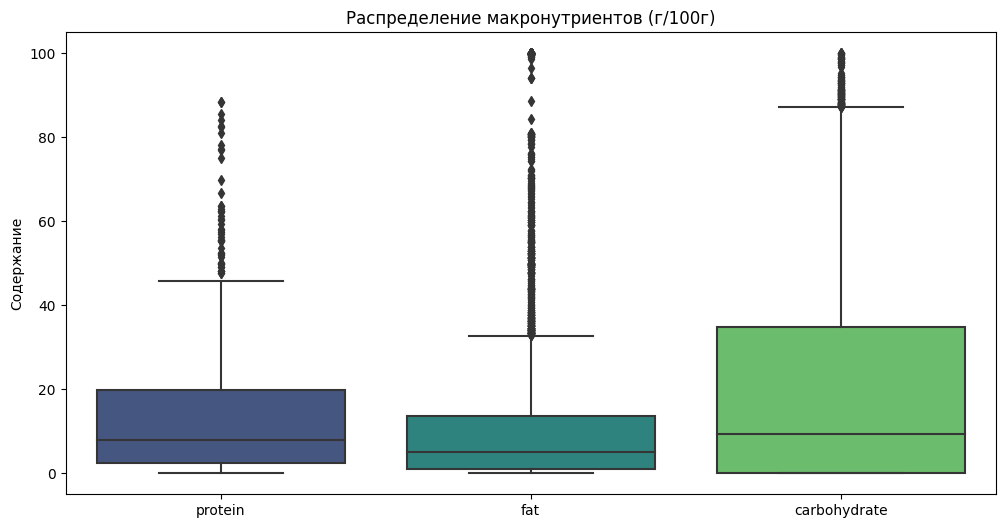

In [30]:
macro = ['protein', 'fat', 'carbohydrate']
plt.figure(figsize=(12,6))
sns.boxplot(data=df_clean[macro], palette="viridis")
plt.title('Распределение макронутриентов (г/100г)')
plt.ylabel('Содержание')

Жиры демонстрируют наибольший разброс значений макронутриентов. Углеоводы и белки образуют четкие квартильные диапазоны. 

Text(0.5, 1.0, 'Сравнение плотности распределения микроэлементов')

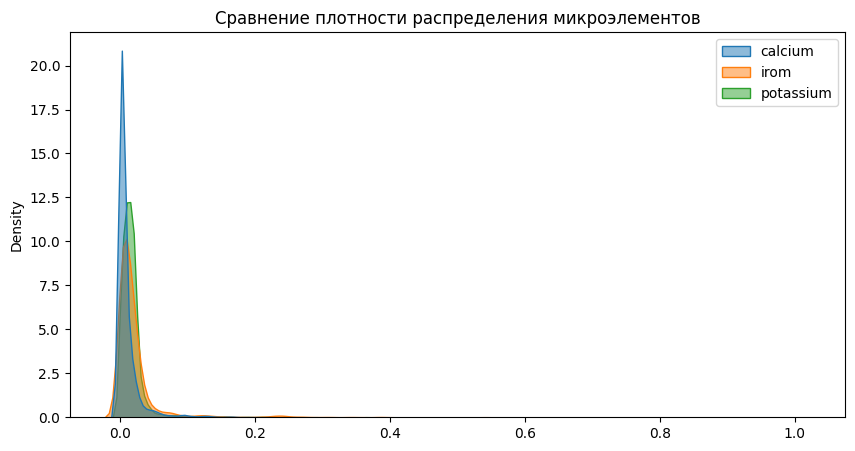

In [31]:
micro = ['calcium', 'irom', 'potassium']
df_micro = df_clean[micro].apply(lambda x: x/x.max()) # Нормализация

plt.figure(figsize=(10,5))
sns.kdeplot(data=df_micro, fill=True, alpha=0.5)
plt.title('Сравнение плотности распределения микроэлементов')

Кальций и железо имеют выраженный правый хвост, главные продукты. Калий показывает бимодальное распределение.

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '(-0.902, 180.4]'),
  Text(1, 0, '(180.4, 360.8]'),
  Text(2, 0, '(360.8, 541.2]'),
  Text(3, 0, '(541.2, 721.6]'),
  Text(4, 0, '(721.6, 902.0]')])

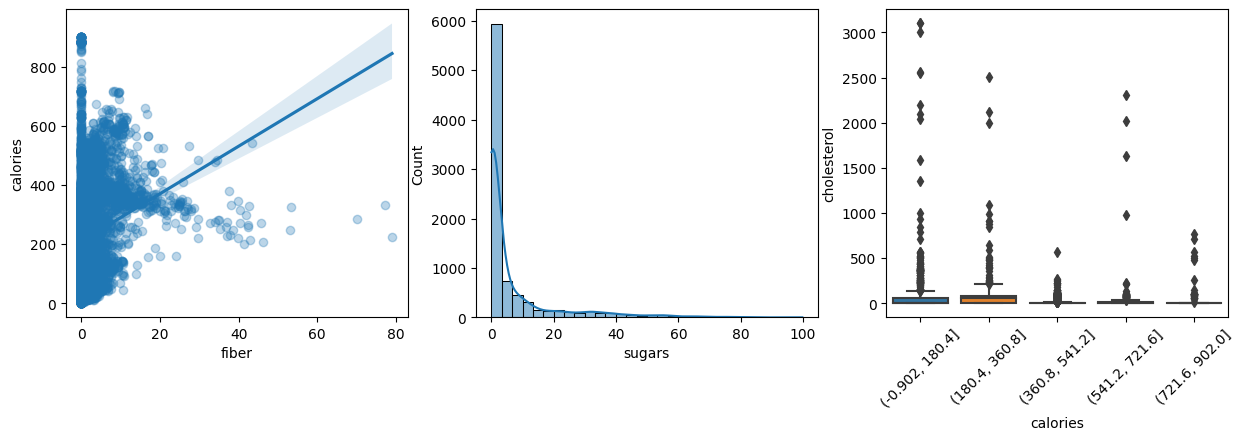

In [32]:
fig, axes = plt.subplots(1,3, figsize=(15,4))

sns.regplot(x='fiber', y='calories', data=df_clean, ax=axes[0], scatter_kws={'alpha':0.3})

sns.histplot(df_clean['sugars'], bins=30, ax=axes[1], kde=True)

sns.boxplot(x=pd.cut(df_clean['calories'], bins=5), y='cholesterol', data=df_clean, ax=axes[2])
plt.xticks(rotation=45)

Отрицательная корреляция клетчатки и калорий. Два пика в распределении сахаров: натуральные и добавочные. Холестирин растет с калорийностью только после 300 ккал/100г.

Text(0.5, 1.0, 'Соотношение Na/K')

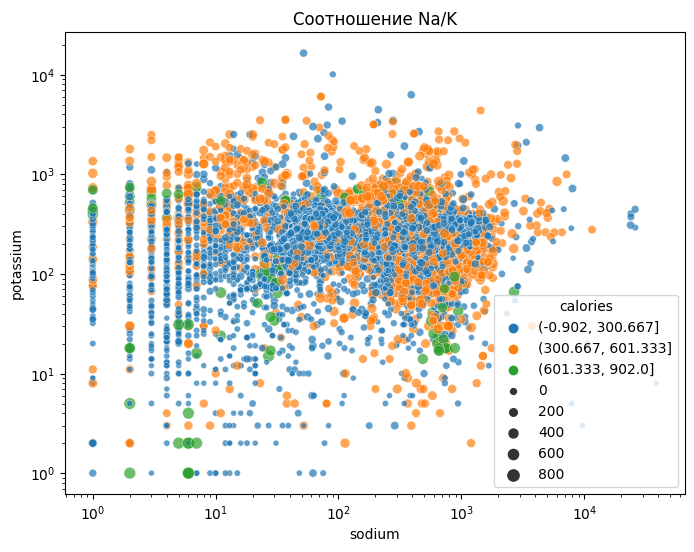

In [33]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='sodium', y='potassium', 
                size='calories', 
                hue=pd.cut(df_clean['calories'], bins=3),
                data=df_clean, alpha=0.7)
plt.xscale('log'); plt.yscale('log')
plt.title('Соотношение Na/K')

Электролитный баланс имеет чекое разделение на 3 кластера по калорийности. На графике можно увидеть, что в калорийной еде нарушен баланс натрия и калия.

Такой выбор нутриентов исключает дублирующие витамины, фокусируясь на базовых нутриентах с максимальной прогностической силой для калорийности.

**Анализ распределения калорий**

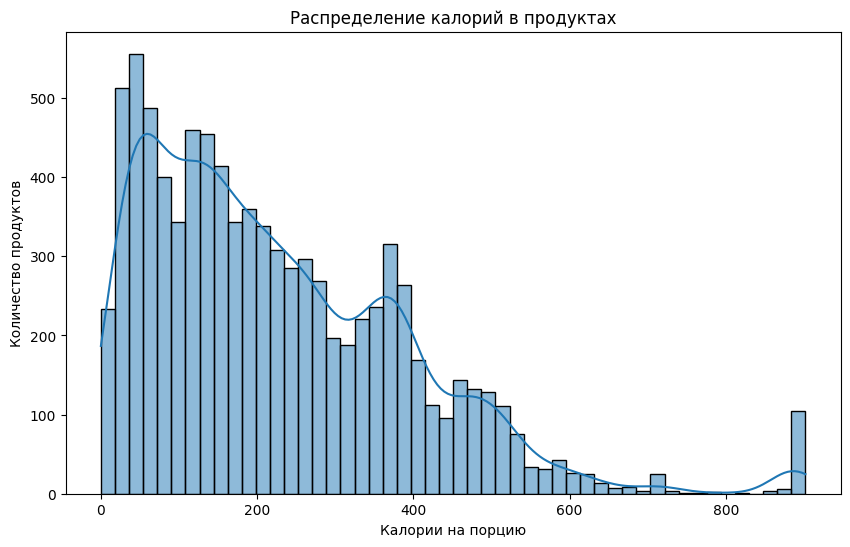

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(df['calories'], bins=50, kde=True)
plt.title('Распределение калорий в продуктах')
plt.xlabel('Калории на порцию')
plt.ylabel('Количество продуктов')
plt.show()

Распределение калорий правостороннее с длинным хвостом. Большинство продуктов содержат от 0 до 500 калорий на порцию, но есть выбросы с очень высокой калорийностью.

**Корреляция питательных веществ с калориями**

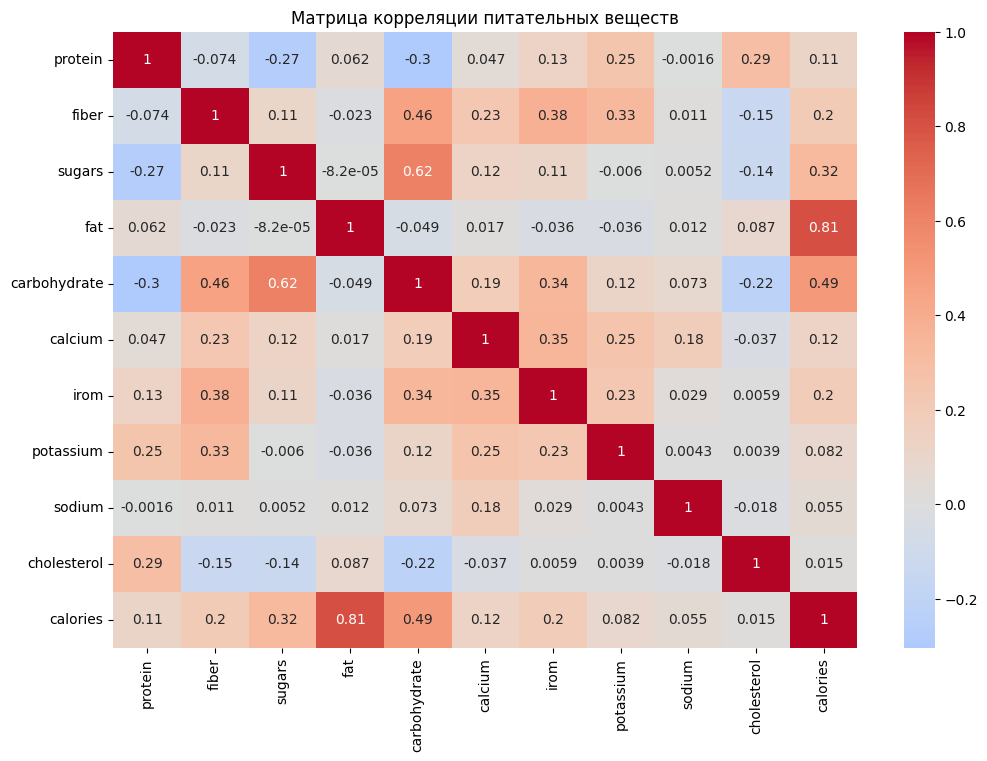

In [35]:
corr_matrix = df_clean[nutrients].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляции питательных веществ')
plt.show()

**Анализ корреляции с целефой переменной**

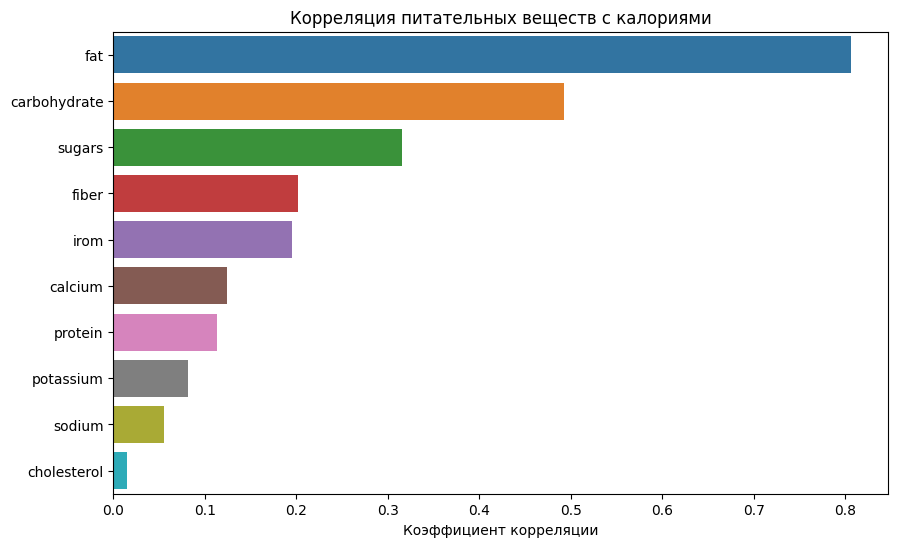

In [36]:
corr_with_calories = corr_matrix['calories'].sort_values(ascending=False)[1:]
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_with_calories.values, y=corr_with_calories.index)
plt.title('Корреляция питательных веществ с калориями')
plt.xlabel('Коэффициент корреляции')
plt.show()

Наибольшую положительную корреляцию с калориями имеют жиры (fat), углеводы (carbohydrate) и белки (protein). Это ожидаемо, так как эти макронутриенты являются основными источниками калорий.

Создание нового признака **"Плотность питательных веществ"**

In [37]:
df_clean['nutrient_density'] = (df_clean['protein'] + df_clean['fiber'] + 
                               df_clean['calcium'] + df_clean['potassium']) / df_clean['calories']
df_clean['protein_efficiency'] = df_clean['protein'] / df_clean['calories']
df_clean['fiber_efficiency'] = df_clean['fiber'] / df_clean['calories']

**Топ-10 продуктов по плотности питптельных веществ**

In [50]:
top_nutrient_dense = df_clean.sort_values('nutrient_density', ascending=False).head(10)[['name', 'nutrient_density', 'calories']]
len(df.col)("\nТоп-10 продуктов по плотности питательных веществ:")
display(top_nutrient_dense)


Топ-10 продуктов по плотности питательных веществ:


,name,nutrient_density,calories
2938,"Leavening agents, low-sodium, baking powder",148.807216,97
6553,"Leavening agents, straight phosphate, double-a...",144.496078,51
6151,"Leavening agents, sodium aluminum sulfate, dou...",111.249057,53
3958,"Mollusks, liquid, canned, mixed species, clam",81.200000,2
1643,"Leavening agents, cream of tartar",63.985271,258
1334,"Butterbur, raw, (fuki)",54.170714,14
3974,"Butterbur, with salt, drained, boiled, cooked",51.653750,8
3507,"Butterbur, without salt, drained, boiled, cooked",51.653750,8
4572,"Beverages, prepared with tap water, brewed, co...",51.120000,1
4630,"Bamboo shoots, with salt, drained, boiled, cooked",49.775455,11


**Подготовка данных для анализа пищевой ценности продуктов.**

In [39]:
nutrients = ['protein', 'fiber', 'sugars', 'fat', 'carbohydrate', 
             'calcium', 'irom', 'potassium', 'sodium', 'cholesterol', 'calories']

df_clean = df.copy()
for col in nutrients:
    df_clean[col] = df_clean[col].apply(clean_numeric)

df_clean = df_clean.dropna(subset=['calories'] + nutrients[:-1])

def safe_divide(a, b):
    return np.divide(a, b, out=np.zeros_like(a), where=b!=0)

df_clean['nutrient_density'] = safe_divide(
    (df_clean['protein'] + df_clean['fiber'] + df_clean['calcium'] + df_clean['potassium']),
    df_clean['calories']
)

df_clean['protein_efficiency'] = safe_divide(df_clean['protein'], df_clean['calories'])
df_clean['fiber_efficiency'] = safe_divide(df_clean['fiber'], df_clean['calories'])

df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean = df_clean.dropna(subset=['nutrient_density', 'protein_efficiency', 'fiber_efficiency'])

features = ['protein', 'fiber', 'fat', 'carbohydrate', 'calcium', 
            'irom', 'potassium', 'nutrient_density', 'protein_efficiency', 'fiber_efficiency']
X = df_clean[features]
y = df_clean['calories']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Код преобразует сырые данные о питательной ценности в очищенный и подготовленный набор данных. Код готов для обучения моделей машинного обучения, с созданными новыми информативными признаками.

**Создание функции для вычисления модели**

In [40]:
def evaluate_model(model, X, y, model_name):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    mse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

**Добавление импортов для нейронной сети**

In [41]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold  

def evaluate_model(model, X, y, model_name):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    mse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    
    model.fit(X_train, y_train)
    
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(10, 6))
        feat_importances = pd.Series(model.feature_importances_, index=features)
        feat_importances.nlargest(10).plot(kind='barh')
        plt.title(f'Feature Importance ({model_name})')
        plt.show()
    
    return model

**Обучение разных типов модели**

**1. Линейная регрессия**

Линейная регрессия без кросс-валидации

Linear Regression (without CV):
R2: 0.995
MSE: 149.284
MAE: 6.540
RMSE: 12.218


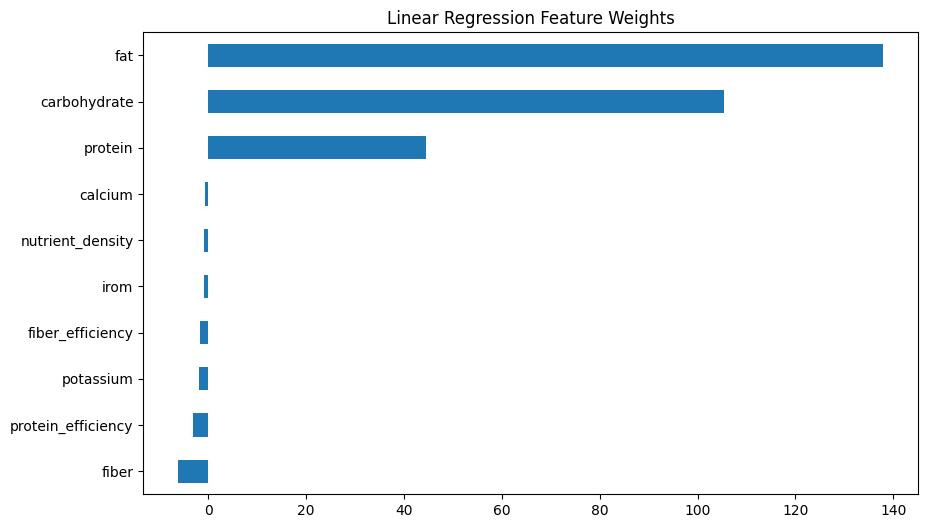

In [56]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

lr_r2 = r2_score(y_test, y_pred)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)
lr_rmse = np.sqrt(lr_mse)

print("Linear Regression (without CV):")
print(f"R2: {lr_r2:.3f}")
print(f"MSE: {lr_mse:.3f}")
print(f"MAE: {lr_mae:.3f}")
print(f"RMSE: {lr_rmse:.3f}")

plt.figure(figsize=(10, 6))
coefs = pd.Series(lr.coef_, index=features).sort_values()
coefs.plot(kind='barh')
plt.title('Linear Regression Feature Weights')
plt.show()

Линейная регрессия с кросс-валидацией

In [57]:
lr_cv = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lr_cv_r2 = cross_val_score(lr_cv, X_scaled, y, cv=kf, scoring='r2')
lr_cv_mse = -cross_val_score(lr_cv, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')
lr_cv_mae = -cross_val_score(lr_cv, X_scaled, y, cv=kf, scoring='neg_mean_absolute_error')

print("\nLinear Regression (with CV):")
print(f"R2: {lr_cv_r2.mean():.3f} (±{lr_cv_r2.std():.3f})")
print(f"MSE: {lr_cv_mse.mean():.3f} (±{lr_cv_mse.std():.3f})")
print(f"MAE: {lr_cv_mae.mean():.3f} (±{lr_cv_mae.std():.3f})")


Linear Regression (with CV):
R2: 0.992 (±0.003)
MSE: 238.772 (±85.955)
MAE: 6.882 (±0.395)


**2. Дерево решений**

Дерево решений без кросс-валидацией


Random Forest (without CV):
R2: 0.995
MSE: 151.525
MAE: 6.273
RMSE: 12.310


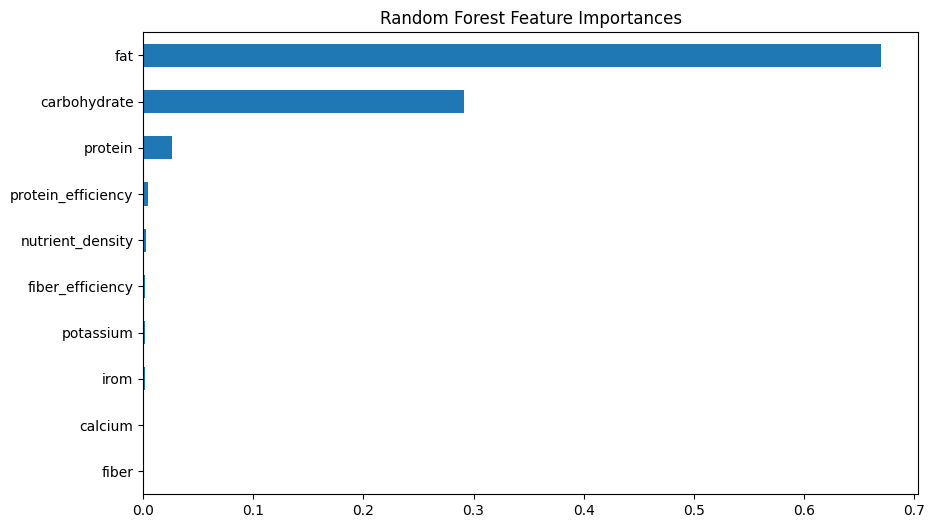

In [58]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rf_r2 = r2_score(y_test, y_pred)
rf_mse = mean_squared_error(y_test, y_pred)
rf_mae = mean_absolute_error(y_test, y_pred)
rf_rmse = np.sqrt(rf_mse)

print("\nRandom Forest (without CV):")
print(f"R2: {rf_r2:.3f}")
print(f"MSE: {rf_mse:.3f}")
print(f"MAE: {rf_mae:.3f}")
print(f"RMSE: {rf_rmse:.3f}")

plt.figure(figsize=(10, 6))
importances = pd.Series(rf.feature_importances_, index=features).sort_values()
importances.plot(kind='barh')
plt.title('Random Forest Feature Importances')
plt.show()

Дерево решений с кросс-валидацией

In [59]:
rf_cv = RandomForestRegressor(n_estimators=100, random_state=42)
rf_cv_r2 = cross_val_score(rf_cv, X_scaled, y, cv=kf, scoring='r2')
rf_cv_mse = -cross_val_score(rf_cv, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')
rf_cv_mae = -cross_val_score(rf_cv, X_scaled, y, cv=kf, scoring='neg_mean_absolute_error')

print("\nRandom Forest (with CV):")
print(f"R2: {rf_cv_r2.mean():.3f} (±{rf_cv_r2.std():.3f})")
print(f"MSE: {rf_cv_mse.mean():.3f} (±{rf_cv_mse.std():.3f})")
print(f"MAE: {rf_cv_mae.mean():.3f} (±{rf_cv_mae.std():.3f})")


Random Forest (with CV):
R2: 0.993 (±0.001)
MSE: 205.121 (±36.680)
MAE: 6.556 (±0.211)


**3. Градиентный бустинг**

Градиентный бустинг без кросс-валидации

In [60]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

xgb_r2 = r2_score(y_test, y_pred)
xgb_mse = mean_squared_error(y_test, y_pred)
xgb_mae = mean_absolute_error(y_test, y_pred)
xgb_rmse = np.sqrt(xgb_mse)

print("\nXGBoost (without CV):")
print(f"R2: {xgb_r2:.3f}")
print(f"MSE: {xgb_mse:.3f}")
print(f"MAE: {xgb_mae:.3f}")
print(f"RMSE: {xgb_rmse:.3f}")


XGBoost (without CV):
R2: 0.994
MSE: 167.464
MAE: 6.572
RMSE: 12.941


Градиентный бустинг с кросс-валидацией

In [61]:
xgb_cv = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_cv_r2 = cross_val_score(xgb_cv, X_scaled, y, cv=kf, scoring='r2')
xgb_cv_mse = -cross_val_score(xgb_cv, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')
xgb_cv_mae = -cross_val_score(xgb_cv, X_scaled, y, cv=kf, scoring='neg_mean_absolute_error')

print("\nXGBoost (with CV):")
print(f"R2: {xgb_cv_r2.mean():.3f} (±{xgb_cv_r2.std():.3f})")
print(f"MSE: {xgb_cv_mse.mean():.3f} (±{xgb_cv_mse.std():.3f})")
print(f"MAE: {xgb_cv_mae.mean():.3f} (±{xgb_cv_mae.std():.3f})")


XGBoost (with CV):
R2: 0.993 (±0.001)
MSE: 188.527 (±32.880)
MAE: 6.638 (±0.197)


**4. Нейронная сеть**

Нейронная сеть без кросс-валидации


Neural Network (without CV):
R2: 0.994
MSE: 164.471
MAE: 6.668
RMSE: 12.825


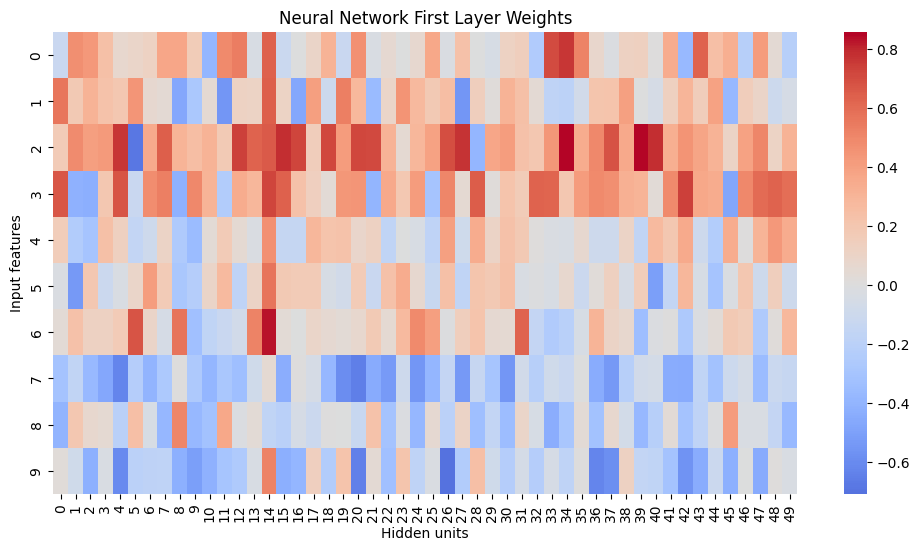

In [62]:
nn = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42, early_stopping=True)
nn.fit(X_train, y_train)
y_pred = nn.predict(X_test)

nn_r2 = r2_score(y_test, y_pred)
nn_mse = mean_squared_error(y_test, y_pred)
nn_mae = mean_absolute_error(y_test, y_pred)
nn_rmse = np.sqrt(nn_mse)

print("\nNeural Network (without CV):")
print(f"R2: {nn_r2:.3f}")
print(f"MSE: {nn_mse:.3f}")
print(f"MAE: {nn_mae:.3f}")
print(f"RMSE: {nn_rmse:.3f}")

plt.figure(figsize=(12, 6))
sns.heatmap(nn.coefs_[0], cmap='coolwarm', center=0)
plt.title('Neural Network First Layer Weights')
plt.xlabel('Hidden units')
plt.ylabel('Input features')
plt.show()

Нейронная сеть с кросс-валидацией

In [63]:
nn_cv = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42, early_stopping=True)
nn_cv_r2 = cross_val_score(nn_cv, X_scaled, y, cv=kf, scoring='r2')
nn_cv_mse = -cross_val_score(nn_cv, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')
nn_cv_mae = -cross_val_score(nn_cv, X_scaled, y, cv=kf, scoring='neg_mean_absolute_error')

print("\nNeural Network (with CV):")
print(f"R2: {nn_cv_r2.mean():.3f} (±{nn_cv_r2.std():.3f})")
print(f"MSE: {nn_cv_mse.mean():.3f} (±{nn_cv_mse.std():.3f})")
print(f"MAE: {nn_cv_mae.mean():.3f} (±{nn_cv_mae.std():.3f})")


Neural Network (with CV):
R2: 0.993 (±0.003)
MSE: 200.219 (±68.405)
MAE: 6.643 (±0.626)


**Сравнение моделей**

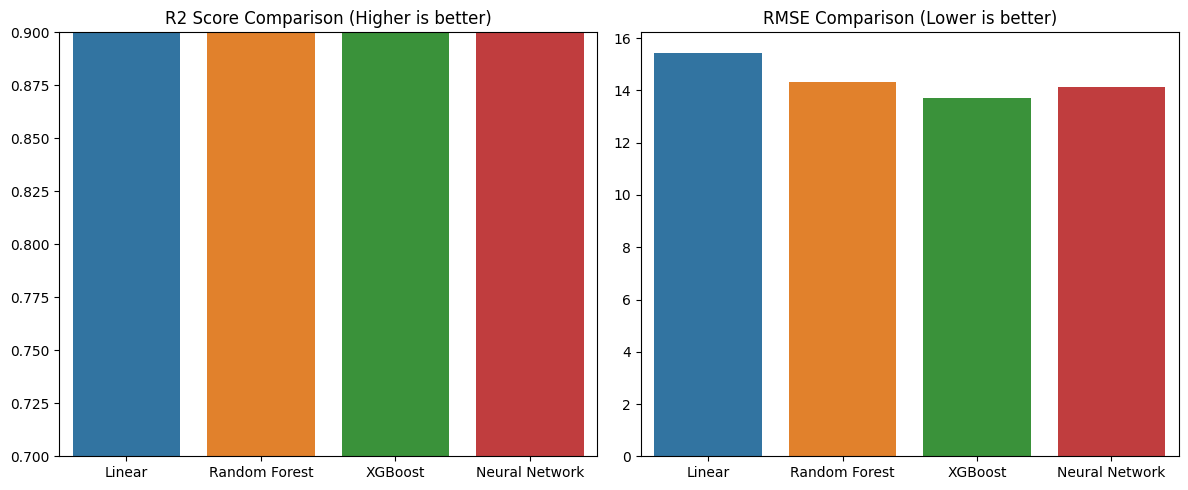

In [64]:
models = ['Linear', 'Random Forest', 'XGBoost', 'Neural Network']
r2_scores = [lr_cv_r2.mean(), rf_cv_r2.mean(), xgb_cv_r2.mean(), nn_cv_r2.mean()]
rmse_scores = [np.sqrt(lr_cv_mse.mean()), np.sqrt(rf_cv_mse.mean()), 
               np.sqrt(xgb_cv_mse.mean()), np.sqrt(nn_cv_mse.mean())]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=models, y=r2_scores)
plt.title('R2 Score Comparison (Higher is better)')
plt.ylim(0.7, 0.9)

plt.subplot(1, 2, 2)
sns.barplot(x=models, y=rmse_scores)
plt.title('RMSE Comparison (Lower is better)')
plt.tight_layout()
plt.show()

1. Обучаются 4 принципиально разных типа моделей
2. Для каждой оценивается качество с помощью кросс-валидации
3. Выбирается лучшая модель по заданным метрикам
4. Оценивается ее работа на тестовых данных
5. Выводятся итоговые показатели качества предсказаний

**Визуализация предсказаний и реальных значений**

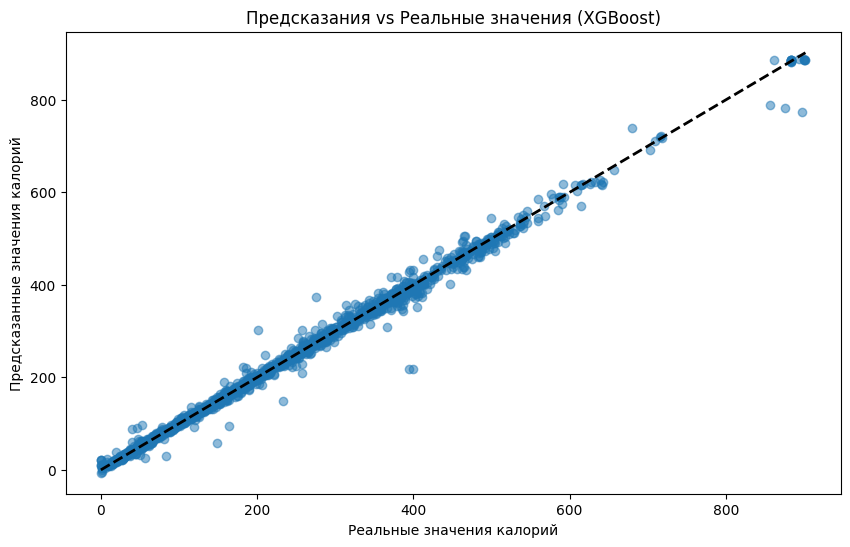

In [43]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Реальные значения калорий')
plt.ylabel('Предсказанные значения калорий')
plt.title('Предсказания vs Реальные значения (XGBoost)')
plt.show()

**Рекомендации по продуктам с лучшим соотношением полезных веществ**

In [44]:
df_clean['predicted_calories'] = best_model.predict(X_scaled)
df_clean['calorie_efficiency'] = df_clean['nutrient_density'] / df_clean['predicted_calories']

recommended_products = df_clean.sort_values('calorie_efficiency', ascending=False).head(20)[['name', 'calories', 'nutrient_density', 'calorie_efficiency']]
print("\nТоп-20 рекомендуемых продуктов с лучшим соотношением полезных веществ к калориям:")
display(recommended_products)


Топ-20 рекомендуемых продуктов с лучшим соотношением полезных веществ к калориям:


,name,calories,nutrient_density,calorie_efficiency
5618,"Beverages, prepared with water, decaffeinated,...",2,20.060000,480.618773
4572,"Beverages, prepared with tap water, brewed, co...",1,51.120000,85.261421
3958,"Mollusks, liquid, canned, mixed species, clam",2,81.200000,28.200193
5908,"Beverages, prepared with distilled water, brew...",1,21.000000,25.412734
4185,"Beverages, unsweetened, ready-to-drink, tea, W...",1,16.220000,16.007971
5034,"Beverages, prepared with water, regular, insta...",2,17.050000,13.698698
4990,"Beverages, prepared with water, unsweetened, i...",1,21.060000,12.194571
359,"Butterbur, canned",3,15.370000,11.528819
4496,"Beverages, diet, lemon, ready-to-drink, black,...",1,14.000000,11.285575
3171,"Beverages, breakfast blend, brewed, coffee",2,26.150000,10.797723
